In [2]:
import pandas as pd
from datetime import datetime
import plotly.express as px

In [4]:
# policy_df=pd.read_csv("policy.csv")
# policy_df[policy_df['end_date'].isnull()]
patient_df=pd.read_csv("patientinfo.csv")
patient_df[patient_df['confirmed_date'].isnull()]
# policy_df['end_date'] = pd.to_datetime(policy_df['end_date'])
# policy_df["end_date"]=policy_df['end_date'].fillna(pd.to_datetime('2020-06-30'))
# policy_df
search_df=pd.read_csv("searchTrend.csv")
start_date = search_df['date'] >= '2020-01-20'
search_df_new=search_df[start_date]
search_df_new
case_df=pd.read_csv("case.csv")
time_df=pd.read_csv("time.csv")


In [5]:
search_df_new['corona_roll_avg'] = search_df_new.iloc[:,4].rolling(window=5).mean()
time_df['confirmed_roll_avg']=time_df.iloc[:,4].rolling(window=7).mean()
merged_df=pd.merge(search_df_new, time_df,how='inner',on='date')
#merged_df = merged_df[['date', 'corona_roll_avg','confirmed_roll_avg']]
merged_df.dropna(inplace=True)
merged_melt=merged_df.melt(id_vars=['date'],value_vars=["corona_roll_avg","confirmed_roll_avg"])

<ipython-input-5-b801cd219b03>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  search_df_new['corona_roll_avg'] = search_df_new.iloc[:,4].rolling(window=5).mean()


In [6]:
import altair as alt

#source = data.stocks()

base=alt.Chart(merged_df).mark_line(stroke='#57A44C').encode(
    alt.X('date:T'),
    alt.Y('confirmed_roll_avg',
          axis=alt.Axis(title='Confirmed Cases 5 days rolling average', titleColor='#57A44C'))
 
)
line = base.mark_line(stroke='#5276A7', interpolate='monotone').encode(
    alt.Y('corona_roll_avg',
          axis=alt.Axis(title='Coronavirus Search Term 5 days rolling average', titleColor='#5276A7'))
)

alt.layer(base, line).properties(width=500).resolve_scale(
    y = 'independent'
)


alt.LayerChart(...)

In [8]:
from scipy.stats import pearsonr
corr, _ = pearsonr(merged_df["confirmed"], merged_df["coronavirus"])
print('Pearsons correlation: %.3f' % corr,_)

Pearsons correlation: -0.817 1.3312614690497448e-38


In [106]:
patient_df_group_state=patient_df.groupby(["age","state"],as_index=False).agg(patient_count=("patient_id","count"))
patient_df_group_age=patient_df.groupby(["age"],as_index=False).agg(patient_count=("patient_id","count"))
patient_deceased_count=patient_df_group_state[patient_df_group_state["state"] =="deceased"]
patient_df_group_age,patient_deceased_count
age_deceased=pd.merge(patient_df_group_age,patient_deceased_count,how="left",on="age")
age_deceased.fillna(0,inplace=True)
age_deceased
corr, _ = pearsonr(age_deceased["patient_count_x"], age_deceased["patient_count_y"])
print('Pearsons correlation: %.3f' % corr,_)


Pearsons correlation: -0.166 0.6251427021200027


,age,patient_count_x,state,patient_count_y
0,0s,66,0,0.0
1,100s,1,0,0.0
2,10s,178,0,0.0
3,20s,899,0,0.0
4,30s,523,deceased,1.0
5,40s,518,deceased,2.0
6,50s,667,deceased,7.0
7,60s,482,deceased,12.0
8,70s,232,deceased,21.0
9,80s,170,deceased,25.0


In [276]:
sort_age=["0s","10s","20s","30s","40s","50s","60s","70s","80s","90s","100s"]
base=alt.Chart(age_deceased).mark_line(stroke='#57A44C').encode(
    alt.X('age:N',sort=sort_age),
    alt.Y('patient_count_x:Q',
          axis=alt.Axis(title='Confirmed Cases', titleColor='#57A44C'))
 
)
line = base.mark_line(stroke='#5276A7', interpolate='monotone').encode(
    alt.Y('patient_count_y:Q',
          axis=alt.Axis(title='Deceased Cases', titleColor='#5276A7'))
)

alt.layer(base, line).properties(width=500).resolve_scale(
    y = 'independent'
)

alt.LayerChart(...)

In [110]:
time_gender_df=pd.read_csv("timegender.csv")

In [269]:
time_gender_df_group=time_gender_df.groupby(["date","sex"],as_index=False).agg(confirmed_count=("confirmed","sum"),Deceased_count=("deceased","sum"))
time_gender_df_group_male= time_gender_df_group[time_gender_df_group["sex"]=="male"]
time_gender_df_group_female= time_gender_df_group[time_gender_df_group["sex"]=="female"]

corr, _ = pearsonr(time_gender_df_group_male["Deceased_count"], time_gender_df_group_female["Deceased_count"])
print('Pearsons correlation: %.3f' % corr,)


Pearsons correlation: 0.996


,date,sex,confirmed_count,Deceased_count
0,2020-03-02,female,2621,9
1,2020-03-02,male,1591,13
2,2020-03-03,female,3002,12
3,2020-03-03,male,1810,16
4,2020-03-04,female,3332,12
...,...,...,...,...
237,2020-06-28,male,5450,151
238,2020-06-29,female,7287,131
239,2020-06-29,male,5470,151
240,2020-06-30,female,7305,131


In [272]:
# import altair as alt

alt.Chart(time_gender_df_group).mark_line().encode(
    x='date:T',
    y='Deceased_count:Q',
    color='sex:N'
)




alt.Chart(...)

In [9]:
time_diff_merge=time_df.set_index('date').diff()
time_diff_merge
time_search_merge=pd.merge(search_df_new,time_diff_merge,how="inner",on="date")
time_search_merge.columns
time_search_merge=time_search_merge[["date",'cold', 'flu', 'pneumonia', 'coronavirus','test', 'negative', 'confirmed', 'released', 'deceased']]
time_search_merge = time_search_merge.assign(IncidencePercent = lambda x: (x['confirmed'] /x["test"]*100 ))
time_search_merge = time_search_merge.assign(NegativeIncident = lambda x: (x['negative'] /x["test"]*100 ))
time_search_merge

,date,cold,flu,pneumonia,coronavirus,test,negative,confirmed,released,deceased,IncidencePercent,NegativeIncident
0,2020-01-20,0.19217,0.70343,3.63716,20.69610,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-21,0.22462,0.59789,4.31987,35.33284,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,2020-01-22,0.23808,0.56661,3.66416,29.74474,3.0,3.0,0.0,0.0,0.0,0.000000,100.000000
3,2020-01-23,0.30308,0.55625,3.18035,100.00000,18.0,18.0,0.0,0.0,0.0,0.000000,100.000000
4,2020-01-24,0.34689,0.40226,2.48156,86.11541,5.0,4.0,1.0,0.0,0.0,20.000000,80.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
157,2020-06-25,0.12072,0.04190,0.11936,2.16993,11881.0,13198.0,28.0,44.0,1.0,0.235670,111.084926
158,2020-06-26,0.11381,0.03027,0.11317,2.15139,11837.0,11870.0,39.0,198.0,0.0,0.329475,100.278787
159,2020-06-27,0.10554,0.02136,0.08354,1.96848,11465.0,10376.0,51.0,145.0,0.0,0.444832,90.501526
160,2020-06-28,0.12563,0.02872,0.08072,2.19720,7915.0,8714.0,62.0,47.0,0.0,0.783323,110.094757


In [10]:
pearsoncorr = time_search_merge.corr(method='pearson')
pearsoncorr


,cold,flu,pneumonia,coronavirus,test,negative,confirmed,released,deceased,IncidencePercent,NegativeIncident
cold,1.000000,0.441977,0.364537,0.659760,-0.258335,-0.323606,0.301383,-0.143039,0.029999,0.359088,-0.280440
flu,0.441977,1.000000,0.867869,0.658271,-0.520832,-0.565089,-0.046689,-0.257324,-0.205283,0.381725,-0.291285
pneumonia,0.364537,0.867869,1.000000,0.643193,-0.480611,-0.519324,-0.063096,-0.250013,-0.210453,0.407982,-0.269004
coronavirus,0.659760,0.658271,0.643193,1.000000,-0.340670,-0.448407,0.409307,-0.315474,-0.064857,0.586203,-0.389787
test,-0.258335,-0.520832,-0.480611,-0.340670,1.000000,0.941235,0.350214,0.181555,0.259471,-0.173510,-0.050204
negative,-0.323606,-0.565089,-0.519324,-0.448407,0.941235,1.000000,0.297044,0.206348,0.272125,-0.187435,0.201646
confirmed,0.301383,-0.046689,-0.063096,0.409307,0.350214,0.297044,1.000000,-0.029601,0.339254,0.446273,-0.060388
released,-0.143039,-0.257324,-0.250013,-0.315474,0.181555,0.206348,-0.029601,1.000000,0.621363,-0.115048,0.168834
deceased,0.029999,-0.205283,-0.210453,-0.064857,0.259471,0.272125,0.339254,0.621363,1.000000,0.068232,0.137062
IncidencePercent,0.359088,0.381725,0.407982,0.586203,-0.173510,-0.187435,0.446273,-0.115048,0.068232,1.000000,-0.047336


<AxesSubplot:>

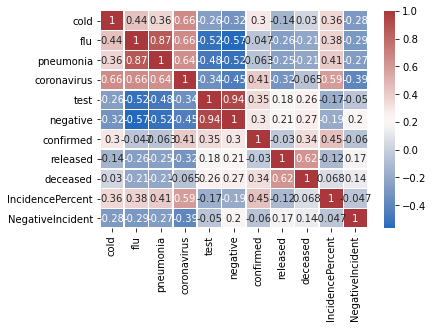

In [11]:
import seaborn as sb
sb.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='vlag',
            annot=True,
            linewidth=0.5)


In [12]:
base=alt.Chart(time_search_merge).mark_line(stroke='#57A44C').encode(
    alt.X('date:T'),
    alt.Y('IncidencePercent:Q',
          axis=alt.Axis(title='Confirmed Incidents', titleColor='#57A44C'))
 
)
line = base.mark_line(stroke='#5276A7', interpolate='monotone').encode(
    alt.Y('NegativeIncident:Q',
          axis=alt.Axis(title='Negative Incidents', titleColor='#5276A7'))
)

alt.layer(base, line).resolve_scale(
    y = 'independent'
)


alt.LayerChart(...)